In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
from tqdm import tqdm
import os

import gym_Snake

from keras import layers,Model,optimizers,losses
import tensorflow as tf

## Loading trained models, preparing the different envs

In [3]:
reward_perso = {"REWARD_TARGET":1,
    "REWARD_COLLISION":-1,
    "REWARD_TOWARD":1/10,
    "REWARD_AWAY":-1/10}

In [4]:
env_classic = gym.make('Snake-v0', 
               player='player', 
               shape='Classic', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=reward_perso)
print(env_classic.observation_space)
print(env_classic.action_space)

Discrete(100)
Discrete(3)


/home/vincent/miniconda3/envs/keras_gpu/lib/python3.10/site-packages/gym/envs/registration.py:619: UserWarning: WARN: Env check failed with the following message: The observation returned by `reset()` method must be an int
You can set `disable_env_checker=True` to disable this check.
  logger.warn(


In [5]:
env_shuriken = gym.make('Snake-v0', 
               player='player', 
               shape='Shuriken', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=reward_perso)
print(env_classic.observation_space)
print(env_classic.action_space)

Discrete(100)
Discrete(3)


In [6]:
env_doubleV = gym.make('Snake-v0', 
               player='player', 
               shape='Double_v', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=reward_perso)
print(env_classic.observation_space)
print(env_classic.action_space)

Discrete(100)
Discrete(3)


In [7]:
env_doubleH = gym.make('Snake-v0', 
               player='player', 
               shape='Double_h', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True,
               rewards=reward_perso)
print(env_classic.observation_space)
print(env_classic.action_space)

Discrete(100)
Discrete(3)


In [8]:
list_env = [env_classic,env_doubleH,env_doubleV,env_shuriken]

In [10]:
model_classic = tf.keras.models.load_model("./final_10x_Classic_50000_smallQ", compile=False)
model_double_v = tf.keras.models.load_model("./final_10x_Double_v_50000_smallQ", compile=False)
model_shuriken = tf.keras.models.load_model("./final_10x_Shuriken_50000_smallQ", compile=False)

In [55]:
model_classic.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 20, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2097280   
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,116,483
Trainable params: 2,116,483
Non-tra

## Training history

In [11]:
classic = pd.read_csv("final_10x_Classic_50000_smallQ.csv",index_col=0,names=["classic"],header=0)
double_v = pd.read_csv("final_10x_Double_v_50000_smallQ.csv",index_col=0,names=["double_v"],header=0)
shuriken = pd.read_csv("final_10x_Shuriken_50000_smallQ.csv",index_col=0,names=["shuriken"],header=0)

history = [classic,double_v,shuriken]
N = [100,1000]

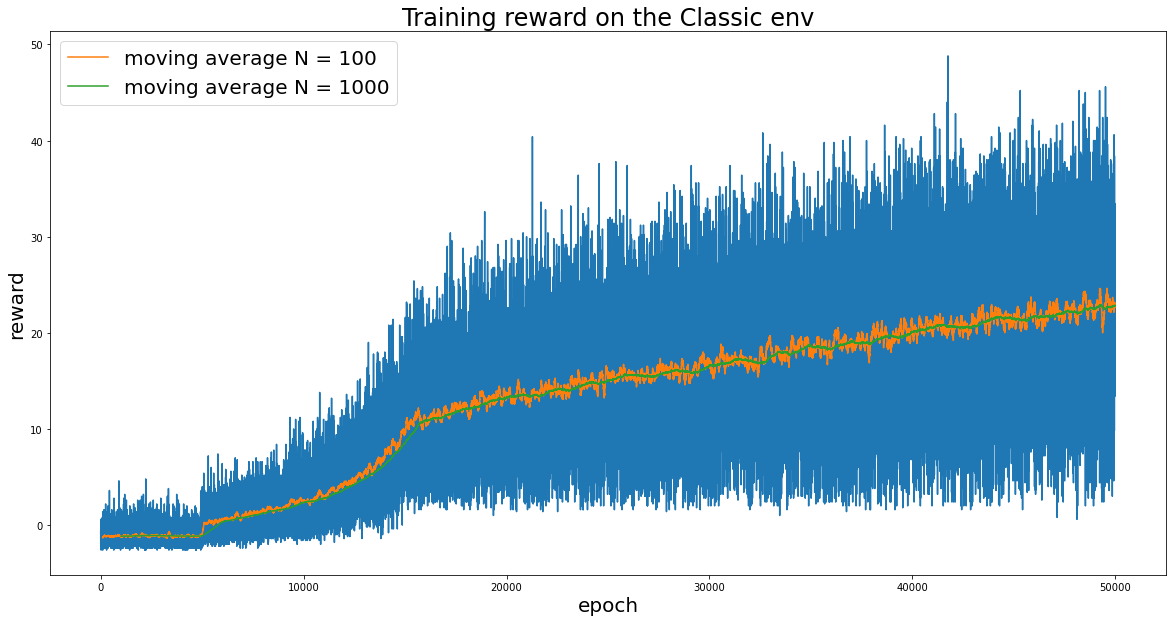

In [21]:
plt.figure(figsize=(20,10))
plt.plot(classic)

for n in N:
    plt.plot(classic.rolling(window=n).mean(),label="moving average N = {}".format(n))

plt.xlabel("epoch",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.title("Training reward on the Classic env",fontsize=24)
plt.legend(fontsize=20)

plt.show()

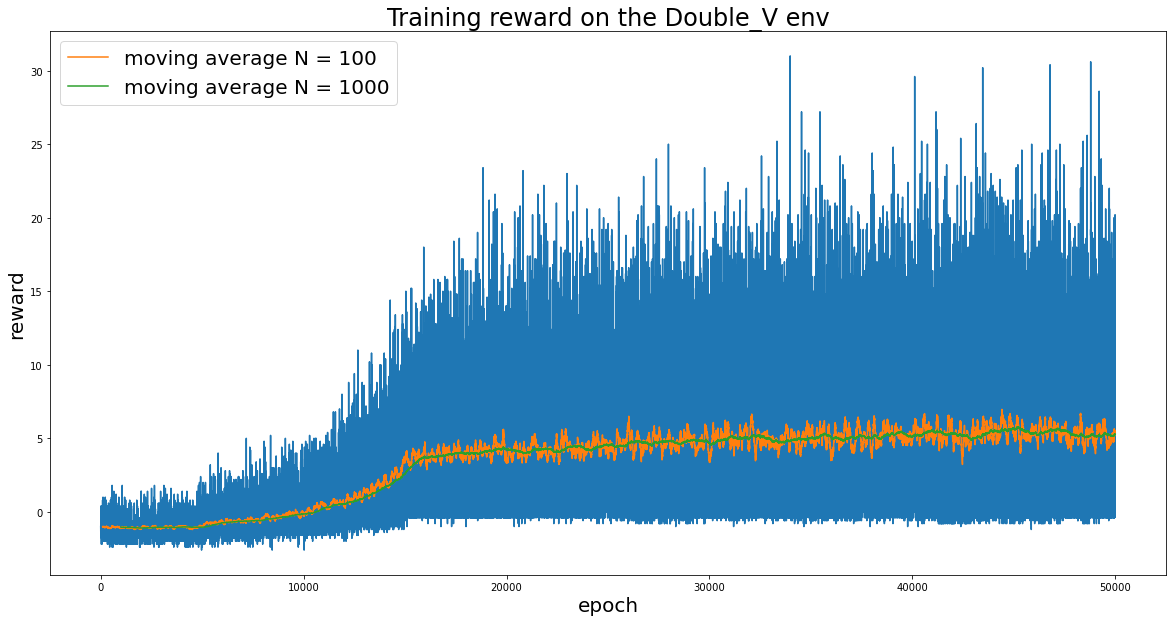

In [26]:
plt.figure(figsize=(20,10))
plt.plot(double_v)

for n in N:
    plt.plot(double_v.rolling(window=n).mean(),label="moving average N = {}".format(n))

plt.xlabel("epoch",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.title("Training reward on the Double_V env",fontsize=24)
plt.legend(fontsize=20)

plt.show()

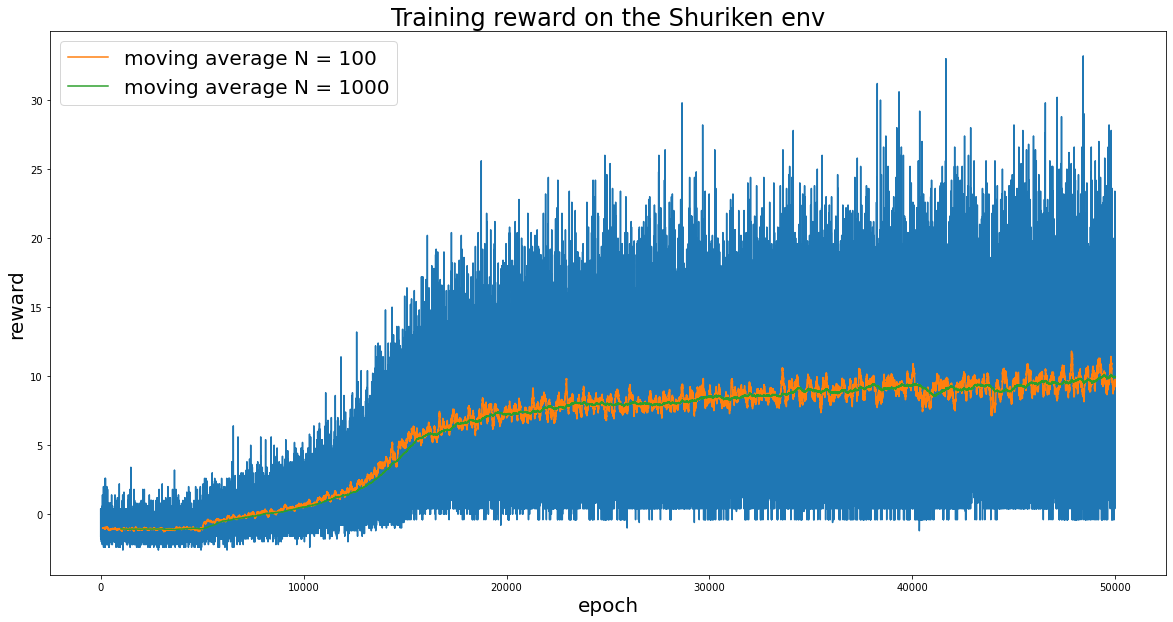

In [27]:
plt.figure(figsize=(20,10))
plt.plot(shuriken)

for n in N:
    plt.plot(shuriken.rolling(window=n).mean(),label="moving average N = {}".format(n))

plt.xlabel("epoch",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.title("Training reward on the Shuriken env",fontsize=24)

plt.legend(fontsize=20)
plt.show()

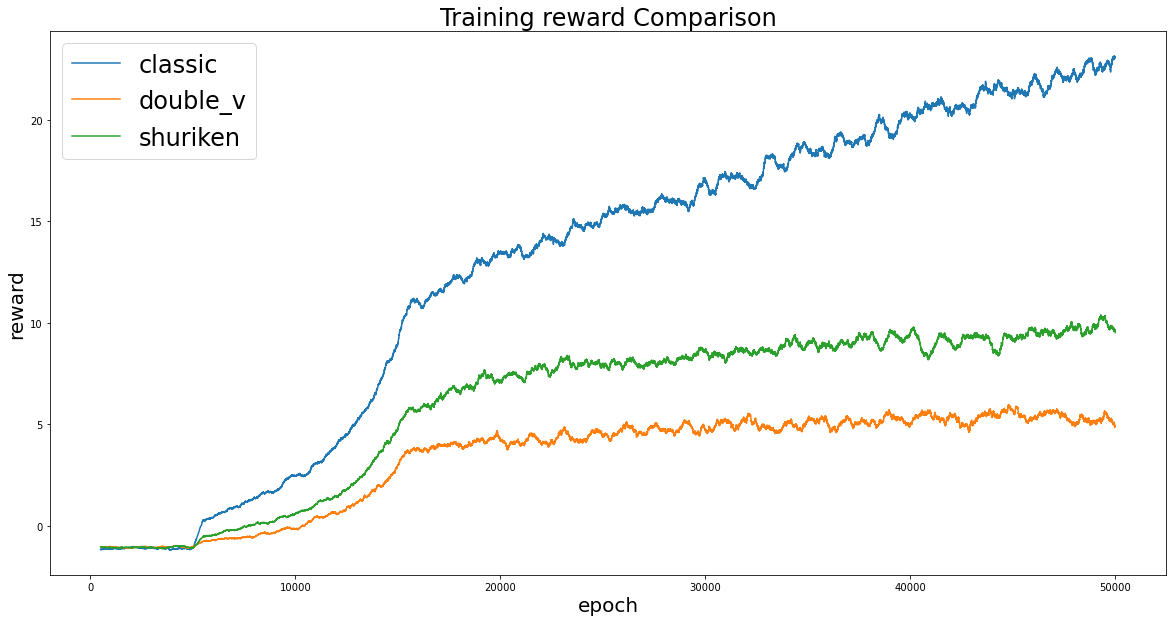

In [30]:
plt.figure(figsize=(20,10))


for env in history:
    plt.plot(env.rolling(window=500).mean(),label=env.columns[0])
    
    
plt.legend(fontsize=24)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.title("Training reward Comparison",fontsize=24)


plt.show()

## Test on different envs

In [59]:
def play_game(env,model,max_steps_per_epoch = 1000,render = False):

    
    state = env.reset().repeat(2,axis=0).repeat(2,axis=1)
    #state = env.reset()
    episode_reward = 0
    
    done = False
    step_counter = 0
    target_eaten = 0
    
    
    while not done and step_counter < max_steps_per_epoch:
        
        step_counter += 1
        
        ###############################
        # Show
        
        if render: env.render()

        ###############################
        # Select Action

        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        ###############################
        # Act in the env

        state_next, reward, done, _ = env.step(action)
        state_next = state_next.repeat(2,axis=0).repeat(2,axis=1)
        ###############################
        # Store reward for that run

        episode_reward += reward  

        if reward == 1:
            target_eaten += 1  

        ###############################
        # Slow render

        if render: time.sleep(0.5)

        ###############################
        # Update state

        state = state_next


    return episode_reward,target_eaten,step_counter

In [60]:
nb_game = 50


### Model trained on classic env

In [61]:

model_classic_reward = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_classic_target = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_classic_survived = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])

In [62]:
for col,env in enumerate(list_env):

    reward_history = []
    target_eaten_history = []
    frame_survived_history = []



    for i in tqdm(range(nb_game)):

        r_episode,target_eaten,frame_survived = play_game(env=env,model=model_classic,render=False)
        reward_history.append(r_episode)
        target_eaten_history.append(target_eaten)
        frame_survived_history.append(frame_survived)

    model_classic_reward[model_classic_reward.columns[col]] = reward_history
    model_classic_target[model_classic_target.columns[col]] = target_eaten_history
    model_classic_survived[model_classic_survived.columns[col]] = frame_survived_history

100%|██████████| 50/50 [00:00<00:00, 93.76it/s] 


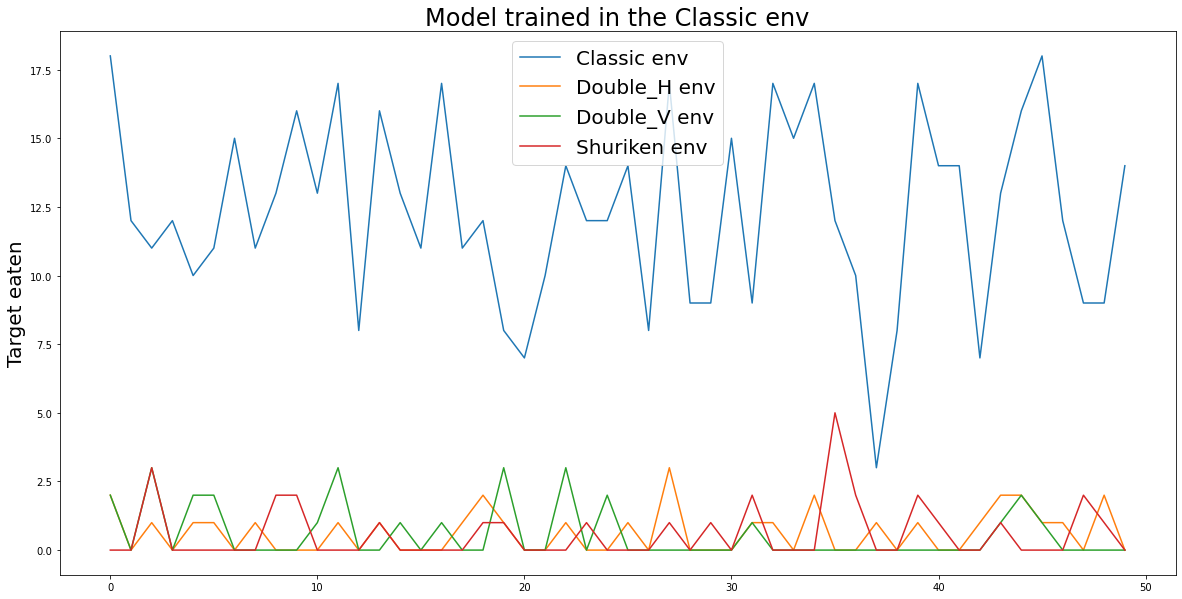

In [63]:
plt.figure(figsize=(20,10))

plt.plot(model_classic_target,label=model_classic_target.columns)
plt.legend(fontsize=20)
plt.title("Model trained in the Classic env",fontsize=24)
plt.ylabel("Target eaten",fontsize=20)
plt.show()

### Model trained on Double_V env


In [64]:
model_doubleV_reward = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_doubleV_target = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_doubleV_survived = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])

In [65]:
for col,env in enumerate(list_env):

    reward_history = []
    target_eaten_history = []
    frame_survived_history = []



    for i in tqdm(range(nb_game)):

        r_episode,target_eaten,frame_survived = play_game(env=env,model=model_double_v,render=False)
        reward_history.append(r_episode)
        target_eaten_history.append(target_eaten)
        frame_survived_history.append(frame_survived)

    model_doubleV_reward[model_doubleV_reward.columns[col]] = reward_history
    model_doubleV_target[model_doubleV_target.columns[col]] = target_eaten_history
    model_doubleV_survived[model_doubleV_survived.columns[col]] = frame_survived_history

100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


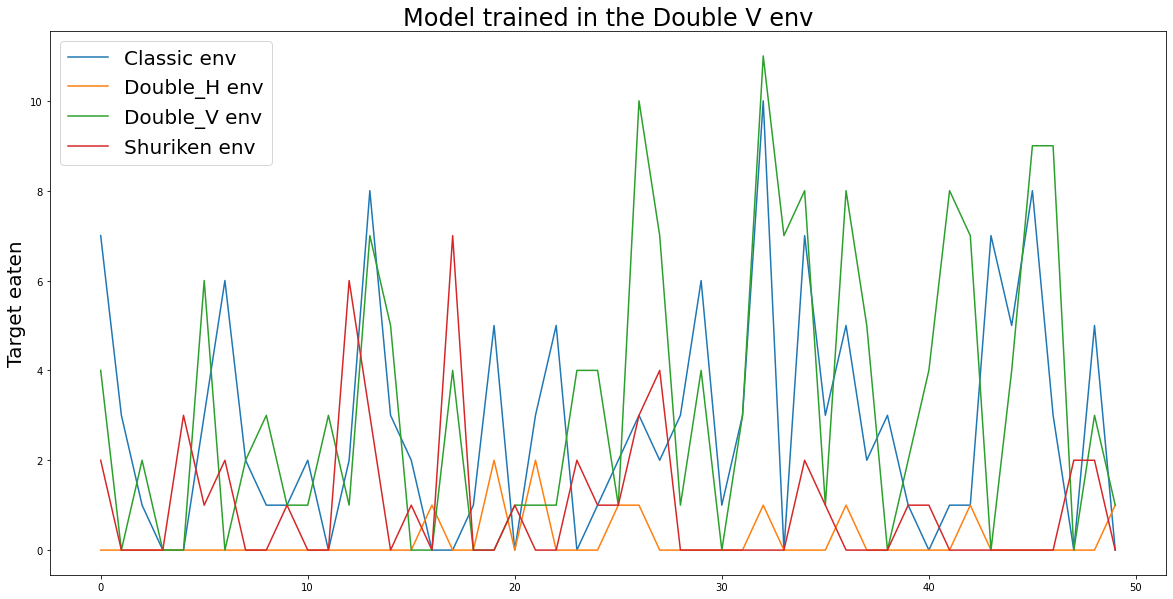

In [66]:
plt.figure(figsize=(20,10))

plt.plot(model_doubleV_target,label=model_doubleV_target.columns)
plt.title("Model trained in the Double V env",fontsize=24)
plt.ylabel("Target eaten",fontsize=20)

plt.legend(fontsize=20)
plt.show()

### Model trained on Shuriken env

In [67]:
model_shuriken_reward = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_shuriken_target = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])
model_shuriken_survived = pd.DataFrame(columns=["Classic env","Double_H env","Double_V env","Shuriken env"])

In [68]:
for col,env in enumerate(list_env):

    reward_history = []
    target_eaten_history = []
    frame_survived_history = []



    for i in tqdm(range(nb_game)):

        r_episode,target_eaten,frame_survived = play_game(env=env,model=model_shuriken,render=False)
        reward_history.append(r_episode)
        target_eaten_history.append(target_eaten)
        frame_survived_history.append(frame_survived)

    model_shuriken_reward[model_shuriken_reward.columns[col]] = reward_history
    model_shuriken_target[model_shuriken_target.columns[col]] = target_eaten_history
    model_shuriken_survived[model_shuriken_survived.columns[col]] = frame_survived_history

100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


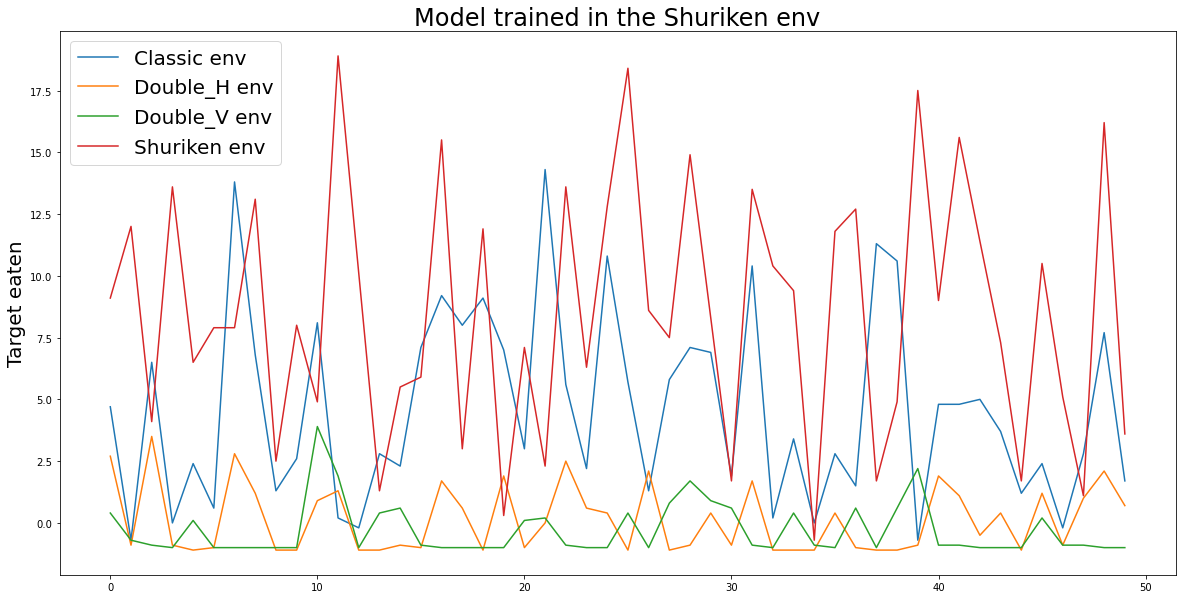

In [69]:
plt.figure(figsize=(20,10))

plt.plot(model_shuriken_reward,label=model_shuriken_reward.columns)
plt.title("Model trained in the Shuriken env",fontsize=24)
plt.ylabel("Target eaten",fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Other

In [70]:
mean_reward = pd.DataFrame()

mean_reward["Trained Classic"] = abs(model_classic_reward.mean(axis=0))
mean_reward["Trained Double V"] = abs(model_doubleV_reward.mean(axis=0))
mean_reward["Trained Shuriken"] = abs(model_shuriken_reward.mean(axis=0))

mean_reward

,Trained Classic,Trained Double V,Trained Shuriken
Classic env,16.980,3.506,4.592
Double_H env,0.016,0.730,0.138
Double_V env,0.222,4.370,0.296
Shuriken env,0.204,0.412,8.524


In [71]:
max_target = pd.DataFrame()

max_target["Trained Classic"] = model_classic_target.mean(axis=0)
max_target["Trained Double V"] = model_doubleV_target.mean(axis=0)
max_target["Trained Shuriken"] = model_shuriken_target.mean(axis=0)

max_target

,Trained Classic,Trained Double V,Trained Shuriken
Classic env,12.32,2.74,3.52
Double_H env,0.64,0.22,0.72
Double_V env,0.56,3.26,0.46
Shuriken env,0.58,0.94,6.60


In [72]:
max_target = pd.DataFrame()

max_target["Trained Classic"] = model_classic_target.std(axis=0)
max_target["Trained Double V"] = model_doubleV_target.std(axis=0)
max_target["Trained Shuriken"] = model_shuriken_target.std(axis=0)

max_target

,Trained Classic,Trained Double V,Trained Shuriken
Classic env,3.419273,2.569920,2.771870
Double_H env,0.776176,0.506690,0.858095
Double_V env,0.972269,3.180361,0.705951
Shuriken env,1.011969,1.544047,3.714286


In [73]:
model_classic_target.std(axis=0)

Classic env     3.419273
Double_H env    0.776176
Double_V env    0.972269
Shuriken env    1.011969
dtype: float64

In [74]:
model_classic_target.mean(axis=0)

Classic env     12.32
Double_H env     0.64
Double_V env     0.56
Shuriken env     0.58
dtype: float64

## Target eaten in a given env

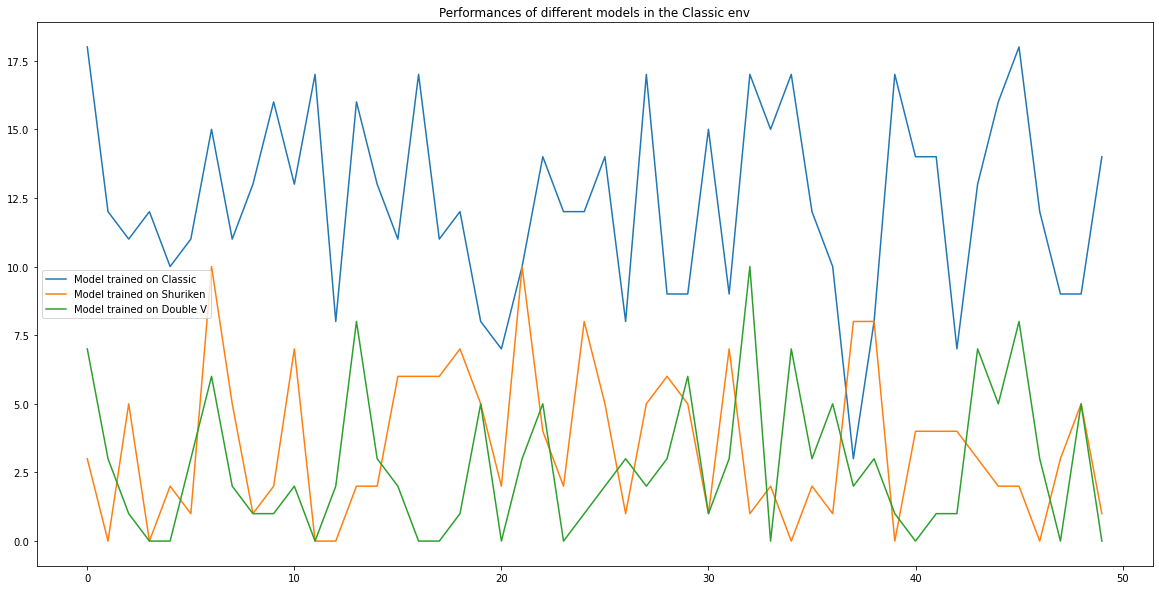

In [75]:
plt.figure(figsize=(20,10))

plt.plot(model_classic_target["Classic env"],label="Model trained on Classic")
plt.plot(model_shuriken_target["Classic env"],label="Model trained on Shuriken")
plt.plot(model_doubleV_target["Classic env"],label="Model trained on Double V")
plt.title("Performances of different models in the Classic env")

plt.legend()
plt.show()

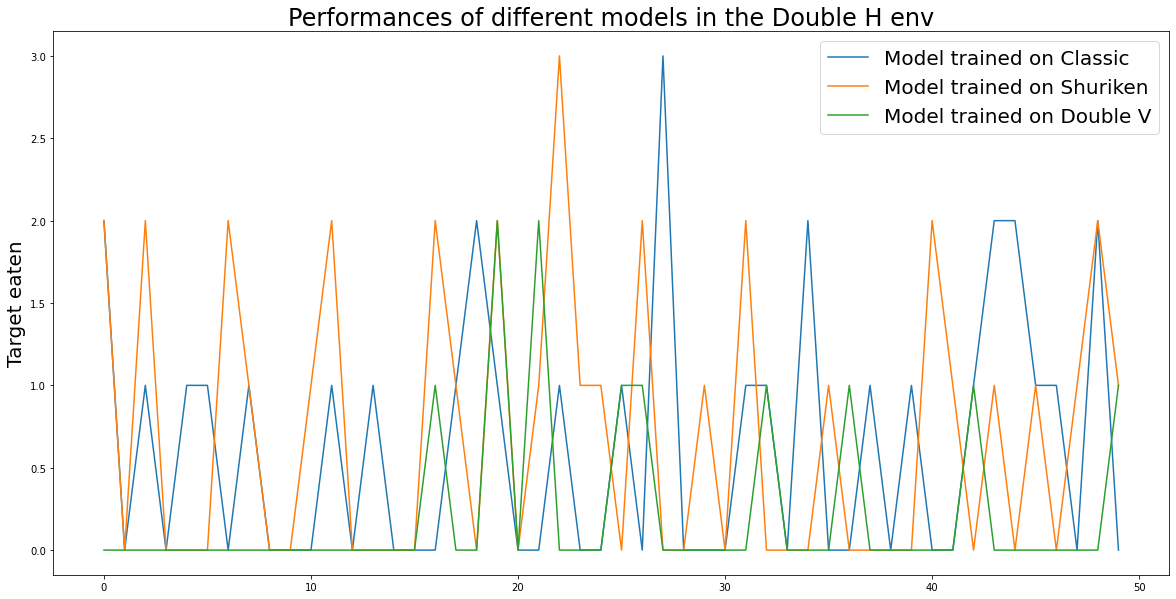

In [76]:
plt.figure(figsize=(20,10))

plt.plot(model_classic_target["Double_H env"],label="Model trained on Classic")
plt.plot(model_shuriken_target["Double_H env"],label="Model trained on Shuriken")
plt.plot(model_doubleV_target["Double_H env"],label="Model trained on Double V")
plt.title("Performances of different models in the Double H env",fontsize=24)
plt.ylabel("Target eaten",fontsize=20)
plt.legend(fontsize=20)
plt.show()

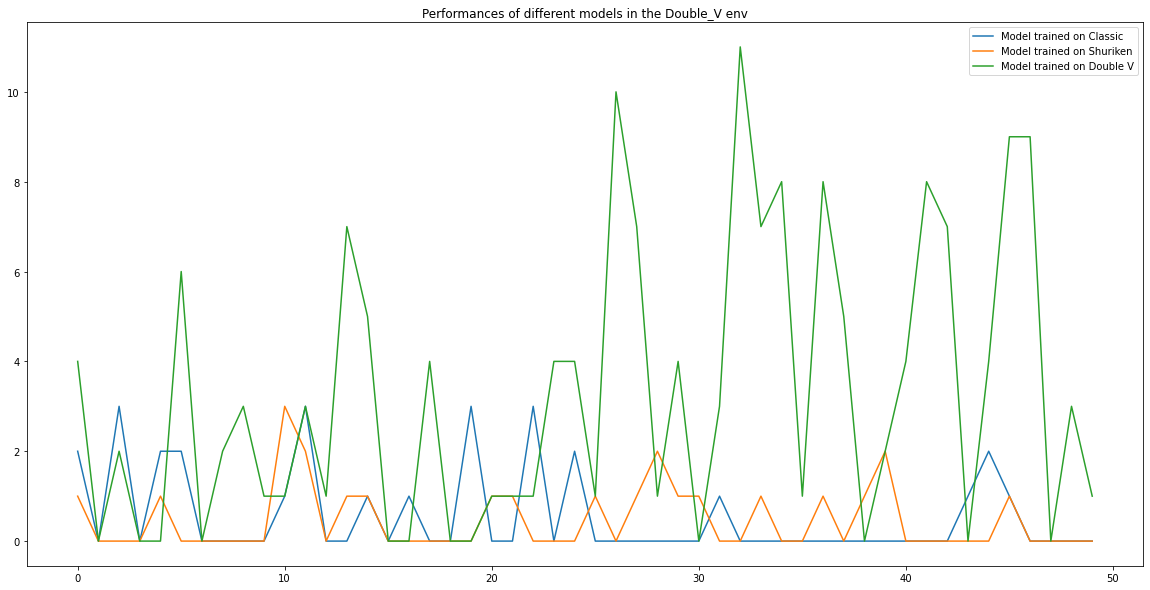

In [77]:
plt.figure(figsize=(20,10))

plt.plot(model_classic_target["Double_V env"],label="Model trained on Classic")
plt.plot(model_shuriken_target["Double_V env"],label="Model trained on Shuriken")
plt.plot(model_doubleV_target["Double_V env"],label="Model trained on Double V")
plt.title("Performances of different models in the Double_V env")

plt.legend()
plt.show()

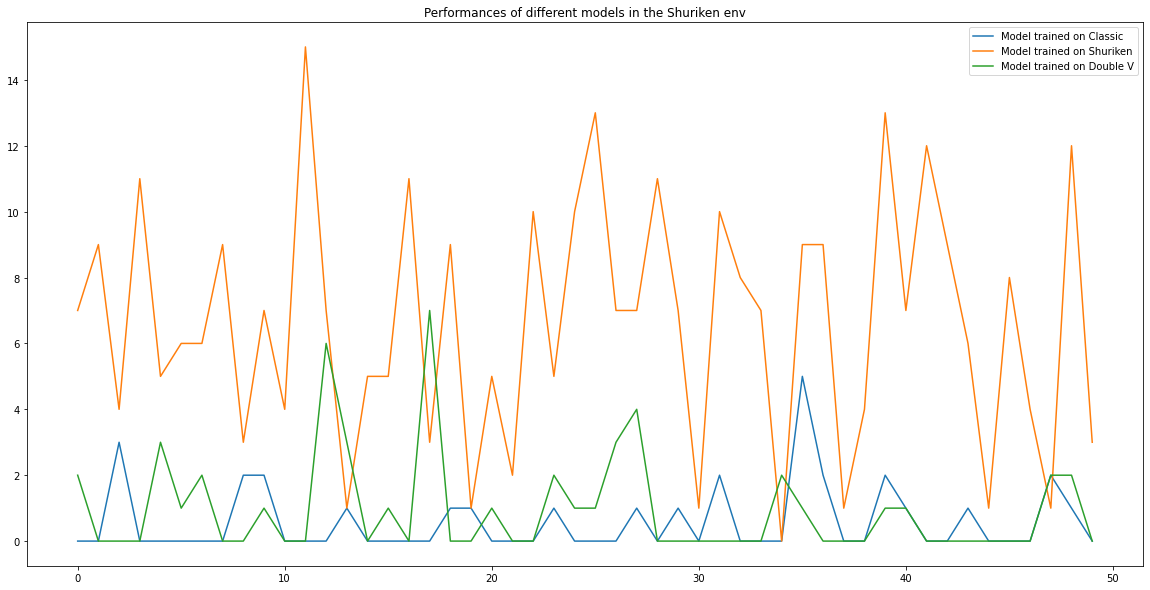

In [78]:
plt.figure(figsize=(20,10))

plt.plot(model_classic_target["Shuriken env"],label="Model trained on Classic")
plt.plot(model_shuriken_target["Shuriken env"],label="Model trained on Shuriken")
plt.plot(model_doubleV_target["Shuriken env"],label="Model trained on Double V")
plt.title("Performances of different models in the Shuriken env")

plt.legend()
plt.show()

### Baseline test

In [113]:
target_eaten_history = []



for i in tqdm(range(200)):

    r_episode,target_eaten,frame_survived = play_game(env=env_classic,model=model_classic,render=False)
    
    target_eaten_history.append(target_eaten)
    

print("mean : {}, median : {}, max : {}".format(np.mean(target_eaten_history),np.median(target_eaten_history),np.max(target_eaten_history)))

100%|██████████| 200/200 [00:43<00:00,  4.65it/s]

mean : 12.125, median : 12.0, max : 21


In [80]:
play_game(env=env_classic,model=model_shuriken,render=True)

(6.9999999999999964, 6, 35)

In [123]:
23/64


0.359375